# Homework: Sonar signal classification
In this workshop you will train a binary classification neural network to differentiate if sonar signals bounced against a metal cylinder or a rock.

[Info of the data](https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+(Sonar,+Mines+vs.+Rocks))

Goal: Get an accuracy higher than 0.80 in the validation set

## Get the data from Google Drive

In [1]:
# Import libraries to interact with Google Drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [2]:
# Authenticate with your Google account to get access to the data
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [28]:
# Download data
download = drive.CreateFile({'id': '1rw5l3jCo2vlNc8NLrMk3KPZr6HsjNRCY'})
download.GetContentFile('sonar.csv')

In [4]:
ls

sample_data/  sonar.csv


## Do some magic below! ;)

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

In [29]:
# Cargar los datos
data = pd.read_csv('sonar.csv', header=None)
data.head()

,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [7]:
# Calcular los valores mínimos y máximos para cada característica para examinar el rango de valores
range_stats = data.describe().loc[['min', 'max']]
range_stats

,0,1,2,3,4,5,6,7,8,9,...,50,51,52,53,54,55,56,57,58,59
min,0.0015,0.0006,0.0015,0.0058,0.0067,0.0102,0.0033,0.0055,0.0075,0.0113,...,0.0000,0.0008,0.0005,0.0010,0.0006,0.0004,0.0003,0.0003,0.0001,0.0006
max,0.1371,0.2339,0.3059,0.4264,0.4010,0.3823,0.3729,0.4590,0.6828,0.7106,...,0.1004,0.0709,0.0390,0.0352,0.0447,0.0394,0.0355,0.0440,0.0364,0.0439


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [30]:
# Encode labels
label_encoder = LabelEncoder()
data[60] = label_encoder.fit_transform(data[60])


In [31]:
# Split the data
X = data.drop(60, axis=1).values
y = data[60].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
# Normalize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [22]:
X_val

array([[ 9.70288455e-02, -2.26646402e-02, -6.14736349e-01, ...,
        -6.11948226e-01, -3.50597965e-01, -8.57287713e-01],
       [ 6.65400628e-02,  8.24616171e-01,  7.70837379e-01, ...,
        -4.91056720e-01,  2.06950327e+00,  1.70647769e-01],
       [-6.25990859e-01, -4.96738428e-01, -1.01197652e+00, ...,
        -3.18354568e-01, -6.17643619e-01, -3.23551982e-01],
       ...,
       [ 1.20695697e-03,  7.70820564e-01,  7.89904908e-01, ...,
        -7.67380162e-01, -5.17501499e-01,  2.89255710e-01],
       [-4.64835864e-01, -6.64849700e-01,  2.97327092e-01, ...,
         1.75407125e+00,  3.63839649e+00, -2.70321310e-02],
       [-3.73369516e-01,  8.15643486e-02, -7.44897117e-02, ...,
        -5.60137581e-01, -4.84120792e-01, -2.04944041e-01]])

In [33]:
# Build the neural network
model = Sequential([
    Dense(128, activation='relu', input_shape=(60,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [24]:
# Configurar el callback ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

In [34]:
# Entrenar el modelo con el callback ModelCheckpoint
history = model.fit(X_train, y_train, epochs=50, batch_size=10, validation_data=(X_val, y_val), callbacks=[checkpoint])

Epoch 1/50
 1/17 [>.............................] - ETA: 22s - loss: 0.5034 - accuracy: 0.9000
Epoch 1: val_accuracy improved from -inf to 0.76190, saving model to best_model.h5
17/17 [==============================] - 2s 23ms/step - loss: 0.6989 - accuracy: 0.5181 - val_loss: 0.5671 - val_accuracy: 0.7619
Epoch 2/50
 1/17 [>.............................] - ETA: 0s - loss: 0.6146 - accuracy: 0.6000
Epoch 2: val_accuracy improved from 0.76190 to 0.80952, saving model to best_model.h5
17/17 [==============================] - 0s 7ms/step - loss: 0.6303 - accuracy: 0.6386 - val_loss: 0.5067 - val_accuracy: 0.8095
Epoch 3/50
 1/17 [>.............................] - ETA: 0s - loss: 0.6437 - accuracy: 0.6000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - ETA: 0s - loss: 0.6206 - accuracy: 0.6446
Epoch 3: val_accuracy did not improve from 0.80952
17/17 [==============================] - 0s 6ms/step - loss: 0.6206 - accuracy: 0.6446 - val_loss: 0.4752 - val_accuracy: 0.7619
Epoch 4/50
 1/17 [>.............................] - ETA: 0s - loss: 0.4290 - accuracy: 0.9000
Epoch 4: val_accuracy did not improve from 0.80952
17/17 [==============================] - 0s 6ms/step - loss: 0.5239 - accuracy: 0.7590 - val_loss: 0.4248 - val_accuracy: 0.7857
Epoch 5/50
17/17 [==============================] - ETA: 0s - loss: 0.4840 - accuracy: 0.7470
Epoch 5: val_accuracy did not improve from 0.80952
17/17 [==============================] - 0s 7ms/step - loss: 0.4840 - accuracy: 0.7470 - val_loss: 0.3850 - val_accuracy: 0.8095
Epoch 6/50
 1/17 [>.............................] - ETA: 0s - loss: 0.3929 - accuracy: 0.9000
Epoch 6: val_accuracy did not improve from 0.80952
17/17 [==============================] - 0s 

In [35]:
# Cargar el mejor modelo guardado
best_model = tf.keras.models.load_model('best_model.h5')

# Evaluar el mejor modelo
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f'Precisión del Mejor Modelo en la Validación: {val_accuracy}')


2/2 [==============================] - 0s 8ms/step - loss: 0.2806 - accuracy: 0.9524
Precisión del Mejor Modelo en la Validación: 0.9523809552192688


95% de accuracy en validación!!

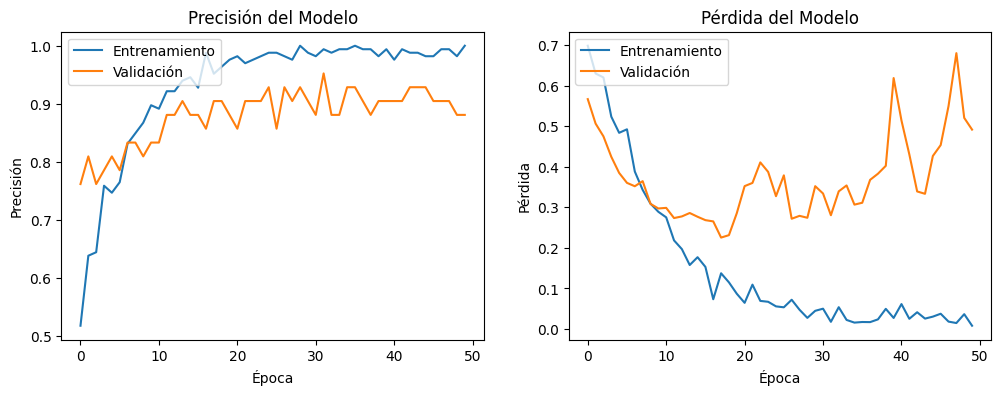

In [36]:
# Graficar valores de precisión de entrenamiento y validación
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Precisión del Modelo')
plt.ylabel('Precisión')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

# Graficar valores de pérdida de entrenamiento y validación
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Pérdida del Modelo')
plt.ylabel('Pérdida')
plt.xlabel('Época')
plt.legend(['Entrenamiento', 'Validación'], loc='upper left')

plt.show()

Bastante overfitting,habria que poner más dropout o quitar nodos, pero nos quedamos con el buen accuracy.